In [1]:
import os.path
import random

import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import networkx as nx
import altair as alt
from IPython.display import display
import matplotlib.pyplot as plt

In [3]:
table = pq.read_table('/home/vast/CGCS-GraphData.parquet', columns=['Source', 'Target', 'eType'])
df = table.to_pandas()
df = df.reset_index()
df = df.drop_duplicates()
df = df.set_index('Source')

In [5]:
print(type(table))
type(df)

<class 'pyarrow.lib.Table'>


pandas.core.frame.DataFrame

## Split by edge type

In [8]:
df_0 = df[df['eType'] == 0].drop(columns='eType')
df_1 = df[df['eType'] == 1].drop(columns='eType')
df_2 = df[df['eType'] == 2].drop(columns='eType')
df_3 = df[df['eType'] == 3].drop(columns='eType')
df_4 = df[df['eType'] == 4].drop(columns='eType')
df_5 = df[df['eType'] == 5].drop(columns='eType')
df_6 = df[df['eType'] == 6].drop(columns='eType')

In [9]:
def df_neighbors(G_df, node, directed=True, in_neighbors=False):
    if directed:
        if node in G_df.index:
            neighbors = G_df.loc[node]['Target']
            if type(neighbors) == np.int64:
                return {neighbors}
            else:
                return set(neighbors)
        else:
            return set()
    elif in_neighbors:
        # compute only in degrees
        neighbors_in = G_df[G_df['Target'] == node].index
            
        if type(neighbors_in) == np.int64:
                neighbors_in = {neighbors_in}
        else:
                neighbors_in = set(neighbors_in)
        return neighbors_in
    else:
        if node in G_df.index:
            neighbors_out = G_df.loc[node]['Target']
        else:
            neighbors_out = set()
                
        neighbors_in = G_df[G_df['Target'] == node].index
        
        if type(neighbors_out) == np.int64:
                neighbors_out = {neighbors_out}
        else:
                neighbors_out = set(neighbors_out)
        
        if type(neighbors_in) == np.int64:
                neighbors_in = {neighbors_in}
        else:
                neighbors_in = set(neighbors_in)
                
#         neighbors = neighbors_in.union(neighbors_out)
        
        return neighbors_in, neighbors_out
        

In [10]:
def compute_node_edge_ratio(df):
    n_edges = len(df)
    n_nodes = len(set(df.index).union(set(df['Target'])))
    return n_edges / n_nodes

In [11]:
def induced_subgraph(G_df, nodes):
    '''
    From a list of nodes returned the induced subgraph in dataframe format
    '''
    nodes_source = [node for node in nodes if node in G_df.index]
    source_filter = G_df.loc[nodes_source, :]
    subgraph_df = source_filter[source_filter['Target'].isin(nodes)]
    return subgraph_df

In [12]:
def random_node(G_df):
    '''select random node'''
    return G_df.sample().index[0]

In [13]:
def random_walk_nodes(G_df, node_start, n_nodes=90):
    dict_neighbors = {}
    visited = {node_start}
    visited_edges = set()
    
    current_node = node_start
    
    while len(visited) < n_nodes:
        if current_node in dict_neighbors.keys():
            neighbors = dict_neighbors[current_node]
        else:
            neighbors = df_neighbors(G_df, current_node, directed)
            dict_neighbors[current_node] = neighbors
            
        if set(neighbors).issubset(visited):
            current_node = random.sample(visited, 1)[0]
            continue
            
        neighbors_deg = {}
        for n in neighbors:
            if n in dict_neighbors.keys():
                neighbors2 = dict_neighbors[n]
            else:
                neighbors2 = df_neighbors(df, n, directed)
            neighbors_deg[n] = len(neighbors2)
            
        neighbors_deg_pond = {n:deg / sum(neighbors_deg.values()) for n, deg in neighbors_deg.items()}
#         print(neighbors_deg_pond)
        
#         print(neighbors)
        # choose which target to choose given their degree
        target_node = np.random.choice(list(neighbors), 1, p=list(neighbors_deg_pond.values()))[0]
        
        # Have to correct the orientation for non directed
        visited_edges.add((current_node, target_node))
        visited.add(target_node)
        
        current_node = target_node
        
    print('random walk finished')
    return visited, visited_edges

In [30]:
# Use in degree to compute the probabilities
def random_walk_nodes_2(G_df, node_start, n_nodes=90):
    dict_neighbors_out = {}
    dict_neighbors_in = {}
    
    visited = {node_start}
    visited_edges = set()
    
    current_node = node_start
    
    while len(visited) < n_nodes:
        if current_node in dict_neighbors_out.keys():
            neighbors = dict_neighbors_out[current_node]
        else:
            neighbors = df_neighbors(G_df, current_node, directed=True)
            dict_neighbors_out[current_node] = neighbors
            
        if set(neighbors).issubset(visited):
            current_node = random.sample(visited, 1)[0]
            continue
            
        neighbors_deg = {}
        for n in neighbors:
            if n in dict_neighbors_in.keys():
                neighbors2 = dict_neighbors_in[n]
            else:
                neighbors2 = df_neighbors(df, n, directed=False, in_neighbors=True)
                dict_neighbors_in[n] = neighbors2
            neighbors_deg[n] = len(neighbors2)
            
        neighbors_deg_pond = {n:deg / sum(neighbors_deg.values()) for n, deg in neighbors_deg.items()}
#         print(neighbors_deg_pond)
        
#         print(neighbors)
        # choose which target to choose given their degree
        target_node = np.random.choice(list(neighbors), 1, p=list(neighbors_deg_pond.values()))[0]
        
        # Have to correct the orientation for non directed
        visited_edges.add((current_node, target_node))
        visited.add(target_node)
        
        current_node = target_node
        
    print('random walk finished')
    return visited, visited_edges

In [25]:
def random_walk_nodes_in_out(G_df, node_start, n_nodes=90):
    dict_neighbors = {}
    visited = {node_start}
    visited_edges = set()
    
    current_node = node_start
    
    while len(visited) < n_nodes:
        if current_node in dict_neighbors.keys():
            neighbors_in, neighbours_out = dict_neighbors[current_node]
        else:
            neighbors_in, neighbours_out = df_neighbors(G_df, current_node, directed=False)
            dict_neighbors[current_node] = (neighbors_in, neighbours_out)
            
        if neighbors_in.issubset(visited) and neighbours_out.issubset(visited):
            current_node = random.sample(visited, 1)[0]
            continue
            
        neighbors_deg = []
        
        neighbors = list(neighbors_in) + list(neighbours_out)
        for n in neighbors:
            if n in dict_neighbors.keys():
                neighbors2_in, neighbors2_out = dict_neighbors[n]
            else:
                neighbors2_in, neighbors2_out = df_neighbors(df, n, directed=False)
            neighbors_deg.append(len(neighbors2_in) + len(neighbors2_out))
            
            
        neighbors_deg_pond = [deg / sum(neighbors_deg) for deg in neighbors_deg]
#         print(neighbors_deg_pond)
        
#         print(neighbors)
        # choose which target to choose given their degree
        node_ind = np.random.choice(len(neighbors), 1, p=neighbors_deg_pond)[0]
        node = neighbors[node_ind]
        
        # Have to correct the orientation for non directed
        if node_ind < len(neighbors_in):
            visited_edges.add((node, current_node))
        else:
            visited_edges.add((current_node, node))
        visited.add(node)
        
        current_node = node
        
    print('random walk finished')
    return visited, visited_edges

In [26]:
def edge_set_todf(edges):
    df = pd.DataFrame(edges, columns=['Source', 'Target']).set_index('Source')
    return df

In [27]:
def extract_subgraph(df, n_nodes=90, directed=True, in_degree=False):
    n_edges = compute_node_edge_ratio(df) * n_nodes 
    
    node_start = random_node(df)
    
    if in_degree:
        selected_nodes, selected_edges = random_walk_nodes_2(df, node_start, n_nodes=n_nodes)
    else:
        if directed:
            selected_nodes, selected_edges = random_walk_nodes(df, node_start, n_nodes=n_nodes)
        else:
            selected_nodes, selected_edges = random_walk_nodes_in_out(df, node_start, n_nodes=n_nodes)
        
#     selected_edges = pd.DataFrame(selected_edges, columns='Source', 'Target')
#     selected_edges = selected_edges.set_index('Source')
    
    induced_graph = induced_subgraph(df, selected_nodes)
    induced_graph = induced_graph.reset_index()
    induced_edges = {tuple(line) for line in induced_graph.values}
    
#     print('induced edges', induced_edges)
#     print('selected edges', selected_edges)
    
    edges_to_sample = list(induced_edges - selected_edges)
    n_edges_to_sample = n_edges - len(selected_edges)
    
    if len(edges_to_sample) < n_edges_to_sample:
        extracted_edges = edges_to_sample
    else:
        # cant directly sample tuples so we take the indexes
        print(edges_to_sample, n_edges_to_sample)
        extracted_edges_ind = np.random.choice(len(edges_to_sample), int(n_edges_to_sample), replace=False)
        extracted_edges = {edge for i, edge in enumerate(edges_to_sample) if i in extracted_edges_ind}
    
    graph_edges = set(extracted_edges).union(induced_edges)
    
    graph_df = edge_set_todf(graph_edges)
    return graph_df

In [18]:
len(df_0)

48263249

In [28]:
import time
def generate_subgraphs_random_walk(G_df, N, size_interval, path, directed, in_degree=False):
    for n in range(N):
        print(n)
        start_time = time.time()
        size = random.randint(size_interval[0], size_interval[1])
        subgraph_df = extract_subgraph(G_df, size, directed=directed, in_degree=in_degree)
        
        subgraph_df.to_csv(path + 'graph' + str(n) + '.csv')
        print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#generate_subgraphs_random_walk(df_0, 10, size_interval=[10,28], path='/home/apister/vastchallenge2020/python/extracted_graphs/random_walk_degree/', directed=True)

0
random walk finished
--- 4826.459768533707 seconds ---
1
random walk finished
--- 5430.356863975525 seconds ---
2
random walk finished
--- 6006.892192363739 seconds ---
3
random walk finished
--- 6280.145518541336 seconds ---
4
random walk finished
--- 7679.791712522507 seconds ---
5
random walk finished
--- 5073.389772415161 seconds ---
6
random walk finished
--- 5587.19556760788 seconds ---
7
random walk finished
--- 3175.322240829468 seconds ---
8
random walk finished
--- 3574.8009202480316 seconds ---
9


In [ ]:
generate_subgraphs_random_walk(df_0, 10, size_interval=[10,28], path='/home/apister/vastchallenge2020/python/extracted_graphs/random_walk_degree_in_out/', directed=False)

0
random walk finished
--- 14101.59578537941 seconds ---
1
random walk finished
--- 22510.172528982162 seconds ---
2
random walk finished
--- 13217.895387887955 seconds ---
3
random walk finished
--- 13766.458391904831 seconds ---
4


In [ ]:
generate_subgraphs_random_walk(df_0, 10, size_interval=[10,28], path='/home/apister/vastchallenge2020/python/extracted_graphs/random_walk_degree_in/', directed=False, in_degree=True)

0
random walk finished
--- 4341.0101482868195 seconds ---
1
random walk finished
--- 6076.751829624176 seconds ---
2
random walk finished
--- 3804.7524597644806 seconds ---
3
random walk finished
--- 6945.71882557869 seconds ---
4
random walk finished
--- 1696.0690624713898 seconds ---
5


# Test on candidate graphs

In [10]:
graph1_path = '/home/vast/MC1/data/Q1-Graph1.csv'

In [11]:
table = pd.read_csv(graph1_path, usecols=['Source', 'Target', 'eType'])
table = table.drop_duplicates()
table = table.set_index('Source')
table.head()

eType  Target
Source               
616050      4  590502
599956      0  635665
599956      0  490041
490041      0  599956
490041      0  635665

In [12]:
graphe1_et0 = table[table['eType'] == 0].drop(columns='eType')

In [13]:
G = nx.from_pandas_edgelist(graphe1_et0.reset_index(), source='Source', target='Target', create_using=nx.DiGraph)

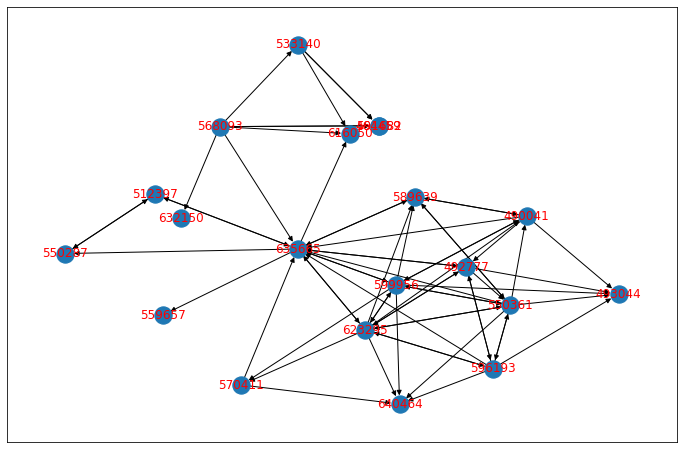

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), ax=axes, font_color='red')

In [175]:
subgraph_test = extract_subgraph(graphe1_et0, n_nodes=10)

random walk finished


In [180]:
subG = nx.from_pandas_edgelist(subgraph_test.reset_index(), source='Source', target='Target', create_using=nx.DiGraph)

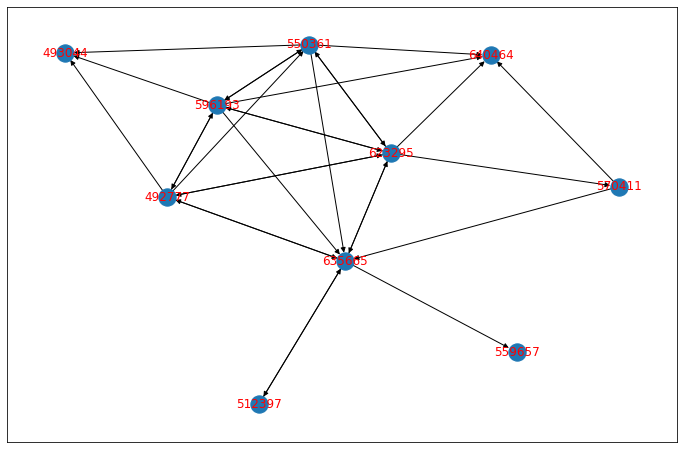

In [181]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
nx.draw_networkx(subG, pos=nx.kamada_kawai_layout(subG), ax=axes, font_color='red')

## Extraction with use of in and out edges

In [32]:
subgraph2 = extract_subgraph(graphe1_et0, n_nodes=10, directed=False)

random walk finished


In [34]:
subG2 = nx.from_pandas_edgelist(subgraph2.reset_index(), source='Source', target='Target', create_using=nx.DiGraph)

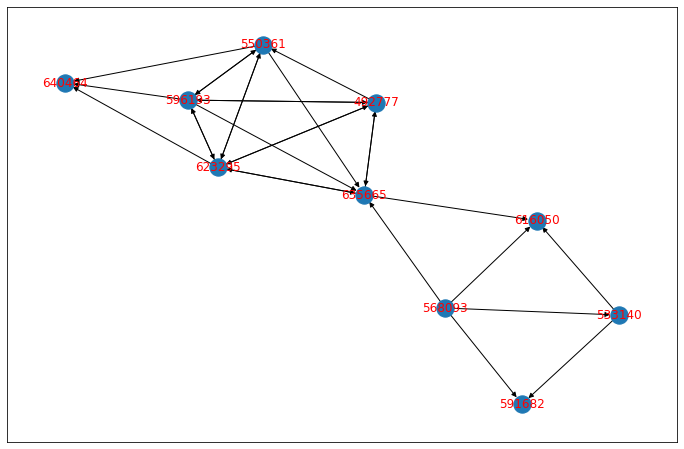

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
nx.draw_networkx(subG2, pos=nx.kamada_kawai_layout(subG2), ax=axes, font_color='red')